In [1]:
#import modules
%pylab inline

from astropy.cosmology import Planck13
from astropy.io import fits
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk,buildQsoSpectrum,save_spectra,load_spectra,restore_qso_grid
from simqso.sqmodels import BOSS_DR9_PLEpivot,get_BossDr9_model_vars
random.seed(12345)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# cover 1000A to 20um at R=1000
wave = sqbase.fixed_R_dispersion(1000,20e4,1000)

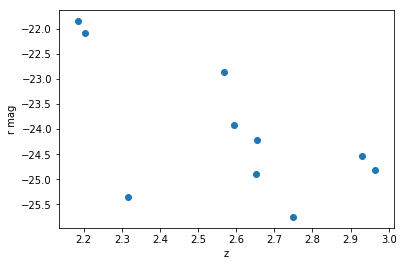

In [3]:
# randomly assigning magnitude and redshift points
nqso = 10 #number of quasars
zin = 2.0 + np.random.rand(nqso)
# fixed magnitude and redshift points
#M = AbsMagVar(FixedSampler(linspace(-27,-25,nqso)[::-1]),restWave=1450)
#z = RedshiftVar(FixedSampler(linspace(2,4,nqso)))
#qsos = QsoSimPoints([M,z],cosmo=Planck13,units='luminosity')
kcorr = sqbase.ContinuumKCorr('DECam-r',1450,effWaveBand='SDSS-r')
qsos = generateQlfPoints(BOSS_DR9_PLEpivot(cosmo=Planck13),
                         (15,23),(2.0,3.0),
                        kcorr=kcorr,zin=zin,
                         qlfseed=12345,gridseed=67890)
scatter(qsos.z,qsos.absMag)
xlabel('z')
ylabel('r mag');


In [4]:
#sedVars = get_BossDr9_model_vars(qsos,wave,0,forestseed=192837465,verbose=1)
#qsos.addVars(sedVars)

In [5]:
# add two dust components as in Lyu+Rieke 2017, but reduce the hot dust flux by a factor of 2
contVar = BrokenPowerLawContinuumVar([GaussianSampler(-1.5,0.3),
                                      GaussianSampler(-0.5,0.3)],
                                    [1215.])

subDustVar = DustBlackbodyVar([ConstSampler(0.05),ConstSampler(1800.)],
                               name='sublimdust')
subDustVar.set_associated_var(contVar)
hotDustVar = DustBlackbodyVar([ConstSampler(0.1),ConstSampler(880.)],
                               name='hotdust')
hotDustVar.set_associated_var(contVar)


In [6]:
# generate lines using the Baldwin Effect emission line model from BOSS DR9
emLineVar = generateBEffEmissionLines(qsos.absMag)

In [7]:
# the default iron template from Vestergaard & Wilkes 2001 was modified to fit BOSS spectra
fescales = [(0,1540,0.5),(1540,1680,2.0),(1680,1868,1.6),(1868,2140,1.0),(2140,3500,1.0)]
feVar = FeTemplateVar(VW01FeTemplateGrid(qsos.z,wave,scales=fescales))

In [8]:
# Now add the features to the QSO grid
#qsos.addVars(contVar)
#qsos.addVars(subDustVar)
#qsos.addVars(hotDustVar)
#qsos.addVars(emLineVar)
#qsos.addVars(feVar)
qsos.addVars([contVar,subDustVar,hotDustVar,emLineVar,feVar])

Simulation of n number of Quasars

In [9]:
# simulation
#qsos.loadPhotoMap([('DECam','DECaLS'),('WISE','AllWISE')])
_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True,maxIter=3,verbose=20)

simulating  10  quasar spectra
units are  flux
buildSpectra iteration  1  out of  1


In [10]:
# data set
qsos.data

z,absMag,appMag,slopes [2],sublimdust [2],hotdust [2],"emLines [62,3]"
float32,float32,float32,float32,float32,float32,float32
2.929616,-24.525948,20.961443,-1.8889757 .. -0.57524747,0.05 .. 1800.0,0.1 .. 880.0,1033.6472 .. 323.155
2.3163755,-25.346842,19.616411,-1.2555648 .. -0.2094757,0.05 .. 1800.0,0.1 .. 880.0,1034.2266 .. 324.4594
2.1839187,-21.84739,22.982542,-1.6081556 .. -0.09002965,0.05 .. 1800.0,0.1 .. 880.0,1033.711 .. 290.71606
2.2045603,-22.077955,22.773327,-1.6336094 .. -0.44678995,0.05 .. 1800.0,0.1 .. 880.0,1034.1235 .. 311.48032
2.567725,-22.864187,22.330471,-1.8769162 .. -0.051912103,0.05 .. 1800.0,0.1 .. 880.0,1033.4891 .. 268.03217
2.5955448,-23.91907,21.299658,-1.573891 .. -0.25440282,0.05 .. 1800.0,0.1 .. 880.0,1034.2821 .. 409.85016
2.9645145,-24.818619,20.694876,-1.4749193 .. -0.86312485,0.05 .. 1800.0,0.1 .. 880.0,1033.0941 .. 253.64166
2.653177,-24.888674,20.379028,-1.7145618 .. -0.33122948,0.05 .. 1800.0,0.1 .. 880.0,1033.6171 .. 270.13806
2.7489066,-25.753618,19.592901,-1.5333737 .. -0.4678067,0.05 .. 1800.0,0.1 .. 880.0,1033.4882 .. 263.72302


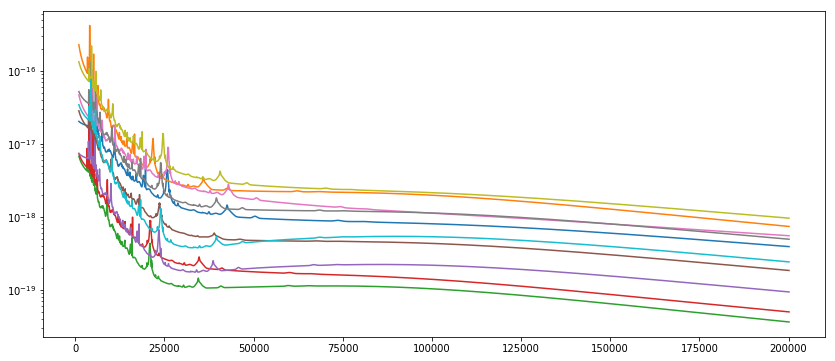

In [11]:
figure(figsize=(14,6))
for sp in spectra:
    plot(wave,sp)
yscale('log')

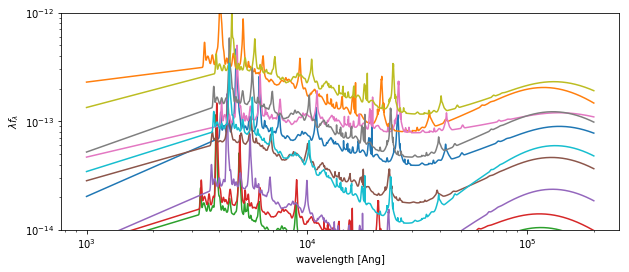

In [12]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$')
ylim(1e-14,1e-12);

(3000, 5500)

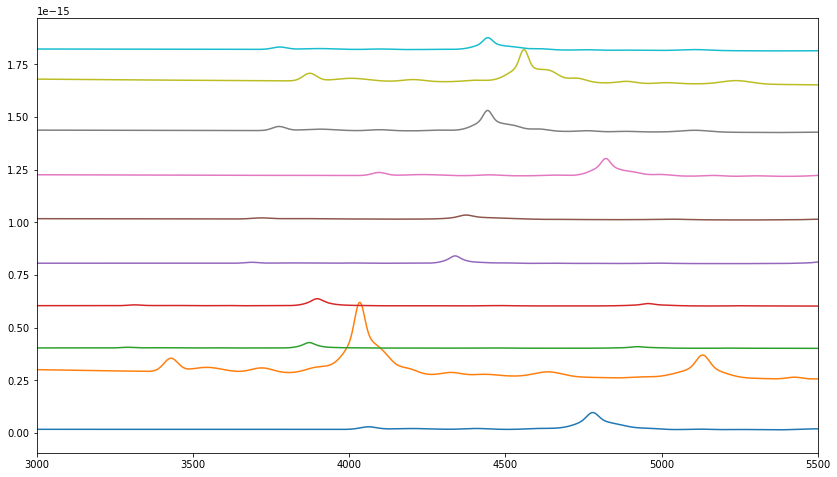

In [13]:
figure(figsize=(14,8))
for i,sp in enumerate(spectra):
    plot(wave,sp+i*2e-16)
xlim(3000,5500)

In [14]:
# compare the resulting SEDs to the mean SED from Lyu+Rieke 2017
from astropy.table import Table
try:
    lr17 = Table.read('apjaa7051t4_mrt.txt',format='ascii')
    lr17wave = array(10**lr17['lambda'])
    lamflam = array(spectra)*wave
    figure(figsize=(8,4))
    for i,z in enumerate(qsos.data['z']):
        j = searchsorted(wave/(1+z),5100)
        fscl = 1/lamflam[i,j]
        plot(wave/(1+z)/1e4,log10(fscl*lamflam[i]))
    j = searchsorted(lr17wave,0.51)
    fscl = lr17['LogL-Norm'][j]
    plot(lr17wave,lr17['LogL-Norm']-fscl,c='k')
    axvline(0.51,c='gray',ls='--')
    xlim(0.1,5)
    ylim(-1,1)
    xscale('log');
except IOError:
    pass

Divide the spectrum into components. Offset the emission line and iron template features for clarity.

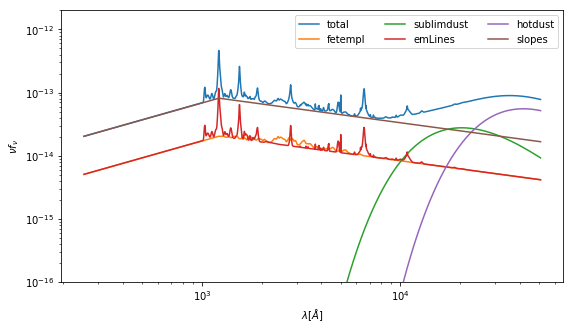

In [15]:
sp,comp = buildQsoSpectrum(wave,qsos.cosmo,qsos.getVars(SpectralFeatureVar),
                           qsos.data[0],save_components=True)
z1 = sp.z + 1
figure(figsize=(9,5))
plot(sp.wave/z1,sp.wave*sp.f_lambda,label='total')
for cname,cspec in comp.items():
    flam = cspec.f_lambda
    if cname in ['emLines','fetempl']:
        flam = 0.25*comp['slopes'].f_lambda*(1+flam)
    plot(cspec.wave/z1,cspec.wave*flam,label=cname)
legend(ncol=3)
ylim(1e-16,2e-12)
xscale('log')
yscale('log')
xlabel('$\lambda [\AA]$')
ylabel(r'$\nu{f}_\nu$');

In [16]:
qsos.write('quasar1_meta',extname='quasar1',overwrite=True)

In [17]:
ff = fits.open('quasar1_meta.fits')
ff.info()

Filename: quasar1_meta.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  QUASAR1       1 BinTableHDU     59   10R x 7C   [E, E, E, 2E, 2E, 2E, 186E]   


In [18]:
save_spectra(wave,spectra,'quasar1')

In [19]:
wave,spec = load_spectra('quasar1')

In [20]:
qsos_restore = restore_qso_grid('quasar1_meta',wave,extname='quasar1')

In [21]:
specs0 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[0])

z,absMag,appMag,slopes [2],sublimdust [2],hotdust [2],"emLines [62,3]"
float32,float32,float32,float32,float32,float32,float32
2.929616,-24.525948,20.961443,-1.8889757 .. -0.57524747,0.05 .. 1800.0,0.1 .. 880.0,1033.6472 .. 323.155


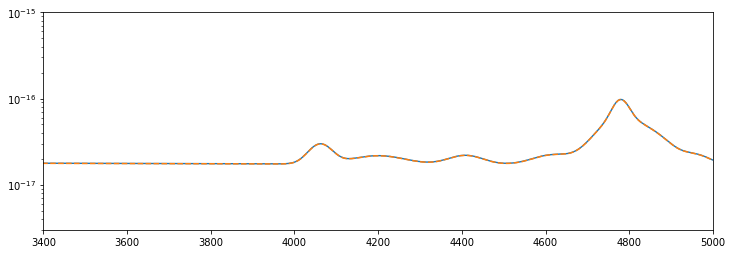

In [22]:
figure(figsize=(12,4))
plot(wave,spectra[0],lw=1.4)
plot(wave,specs0.f_lambda,ls='--')
yscale('log')
ylim(3e-18,10e-16)
xlim(3400,5000);#1e4);
qsos.data[0]

In [23]:
spec1 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[1])

z,absMag,appMag,slopes [2],sublimdust [2],hotdust [2],"emLines [62,3]"
float32,float32,float32,float32,float32,float32,float32
2.3163755,-25.346842,19.616411,-1.2555648 .. -0.2094757,0.05 .. 1800.0,0.1 .. 880.0,1034.2266 .. 324.4594


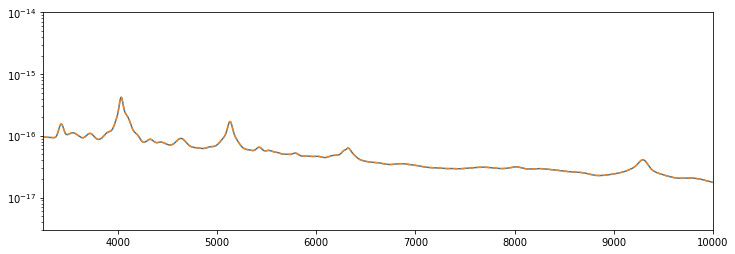

In [24]:
figure(figsize=(12,4))
plot(wave,spectra[1],lw=1.4)
plot(wave,spec1.f_lambda,ls='--')
yscale('log')
ylim(3e-18,10e-15)
xlim(3250,1e4);
qsos.data[1]

In [25]:
_,allspec = buildSpectraBulk(wave,qsos_restore)

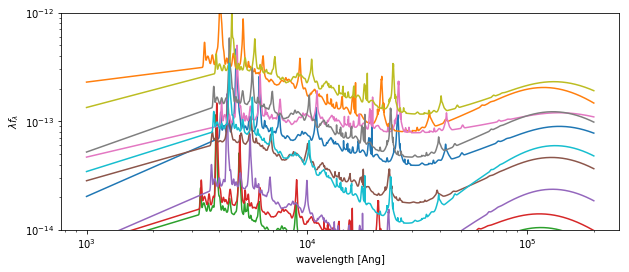

In [26]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$')
ylim(1e-14,1e-12);

In [27]:
spec2 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[2])

z,absMag,appMag,slopes [2],sublimdust [2],hotdust [2],"emLines [62,3]"
float32,float32,float32,float32,float32,float32,float32
2.1839187,-21.84739,22.982542,-1.6081556 .. -0.09002965,0.05 .. 1800.0,0.1 .. 880.0,1033.711 .. 290.71606


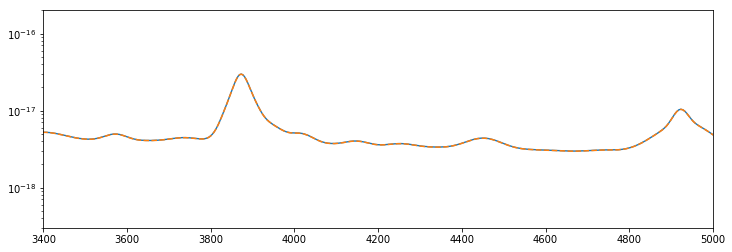

In [28]:
figure(figsize=(12,4))
plot(wave,spectra[2],lw=1.4)
plot(wave,spec2.f_lambda,ls='--')
yscale('log')
ylim(3e-19,2e-16)
xlim(3400,5000);#1e4);
qsos.data[2]

In [29]:
spec3 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[3])

z,absMag,appMag,slopes [2],sublimdust [2],hotdust [2],"emLines [62,3]"
float32,float32,float32,float32,float32,float32,float32
2.2045603,-22.077955,22.773327,-1.6336094 .. -0.44678995,0.05 .. 1800.0,0.1 .. 880.0,1034.1235 .. 311.48032


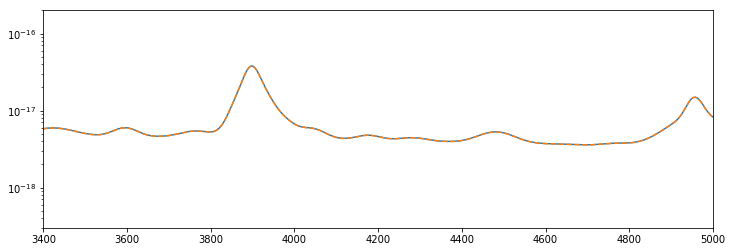

In [30]:
figure(figsize=(12,4))
plot(wave,spectra[3],lw=1.4)
plot(wave,spec3.f_lambda,ls='--')
yscale('log')
ylim(3e-19,2e-16)
xlim(3400,5000);#1e4);
qsos.data[3]